In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import GPy, scipy
import time as timemodule

from gp_growth import classical, factory, metric
from gp_growth.data.growth import GrowthData

In [3]:
%matplotlib inline

In [4]:
gpFactory = factory.Factory()
mse = metric.MeanSquareError(factory=gpFactory)
muMax = metric.MuMax_simple(factory=gpFactory,n=100)
carryingCapacity = metric.CarryingCapacity_simple(factory=gpFactory)

In [5]:
data = pd.read_csv("../data/processed/combined.csv")
data.shape

(800, 106)

In [7]:
timeind = 9
time = data.columns[timeind:].astype(float)

In [8]:
reload(classical)

<module 'gp_growth.classical' from '../gp_growth/classical.pyc'>

In [16]:
output = pd.DataFrame()

for i in range(output.shape[0],data.shape[0]):
    od = np.log2(data.iloc[i,timeind:].tolist())
    od = od - od[0]
    design = params = data.iloc[i,:timeind]
    params = pd.DataFrame([params.values],columns=params.index,index=[params.name])
    
    if design.Strain == "blank":
        continue
    
    key = pd.DataFrame(design).T
    key['well'] = 0
    temp = GrowthData(pd.DataFrame(zip(time.tolist(),od.tolist()),columns=['time',params.index[0]]),key)
    edata = temp.getData("gp")
    
    n = edata.shape[0]
    train = range(n)
    test = range(0,n,5)
    [train.remove(x) for x in test]
    cv = [train,test]
    
#     print i,n, len(train),len(test)
    
    edata_train = edata.iloc[train,:]
    edata_test = edata.iloc[test,:]
    
    # GP MSE
    
    try:
        start = timemodule.time()
        gp = gpFactory.build(edata_train,optimize=True)
        stop = timemodule.time()

        params['gp_mse'] = mse.compute(edata_test,gp)
        params['gp_muMax_mean'],params['gp_muMax_std'] = muMax.compute(predictive_data=temp,model=gp)
        params['gp_CarryingCapacity_mean'],params['gp_CarryingCapacity_std'] = carryingCapacity.compute(predictive_data=temp,model=gp)
        params['gp_loglikelihood'] = gp.log_likelihood()
        params['gp_time'] = stop - start
    except Exception,e:
        print e
        params['gp_mse'] = [np.nan]
        params['gp_muMax_mean'],params['gp_muMax_std'] = [np.nan,np.nan]
        params['gp_CarryingCapacity_mean'],params['gp_CarryingCapacity_std'] = [np.nan,np.nan]
        params['gp_loglikelihood'] = [np.nan]
        params['gp_time'] = [np.nan]
        
    # Gompertz
    start = timemodule.time()
    m,A,l,gmse = classical.optimize(edata.time.values,edata.od.values,cv=cv)
    stop = timemodule.time()
    params['gompertz_muMax'] = m
    params['gompertz_CarryingCapacity'] = A
    params['gompertz_lagTime'] = l
    params['gompertz_mse'] = gmse
    params['gompertz_time'] = stop - start
    
    # Logistic
    m,A,l,gmse = classical.optimize(edata.time.values,edata.od.values,classical.logistic,cv=cv)
    params['logistic_muMax'] = m
    params['logistic_CarryingCapacity'] = A
    params['logistic_lagTime'] = l
    params['logistic_mse'] = gmse
    
    # Richards
    m,A,l,gmse = classical.optimize(edata.time.values.astype(float),edata.od.values.astype(float),classical.richards,p0=(.1,1,1,5),cv=cv)
    params['richards_muMax'] = m
    params['richards_CarryingCapacity'] = A
    params['richards_lagTime'] = l
    params['richards_mse'] = gmse
    
    #Schnute
    m,A,l,gmse = classical.optimize(edata.time.values.astype(float),edata.od.values.astype(float),classical.schnute,p0=(.1,1,1,0.1,.1),cv=cv)
    params['schnute_muMax'] = m
    params['schnute_lagTime'] = l
    params['schnute_mse'] = gmse
        
    if output.shape[0]==0:
        output = params
    else:
        output = output.append(params)

    output.to_csv("classical_models.csv",index=False)

not positive definite, even with jitter.
not positive definite, even with jitter.
not positive definite, even with jitter.
not positive definite, even with jitter.
not positive definite, even with jitter.
not positive definite, even with jitter.


In [ ]:
output.columns

In [ ]:
sum(output.gompertz_muMax.isnull())

In [ ]:
sum(output.gp_muMax_mean.isnull())

# Example fits

In [ ]:
g = data.groupby(['Strain','mM PQ'])

 /home/ptonner/dev/gp_growth_phenotype/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning:Covariance of the parameters could not be estimated


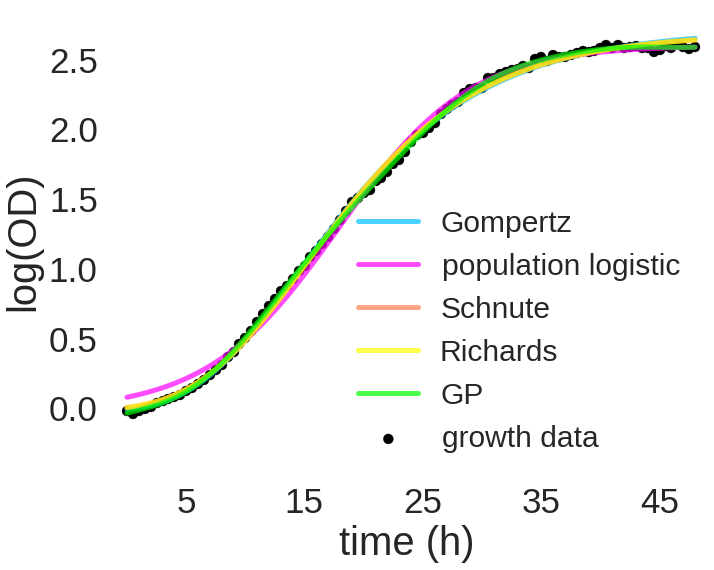

In [9]:
od = g.get_group(('ura3',0)).values[10,timeind:]
od = np.log2(od.tolist())
od = od - od[0]

# plt.figure(figsize=(8,6))
plt.figure(figsize=(10,8))
plt.scatter(time,od,c='k',alpha=1,s=100,label='growth data')
plt.xlim(-2,49)
# plt.title("Standard growth",fontsize=40)
plt.xlabel("time (h)",fontsize=40)
plt.ylabel("log(OD)",fontsize=40)
plt.xticks([5,15,25,35,45],fontsize=35)
plt.ylim(-.49,2.9)
plt.yticks(fontsize=35)

linewidth=5
alpha=.7

m,A,l,mse = classical.optimize(time,od)
predict = np.array([classical.gompertz(t,m,A,l) for t in time])
plt.plot(time,predict,color="deepskyblue",linewidth=linewidth,label="Gompertz",alpha=alpha)

m,A,l,mse = classical.optimize(time,od,classical.logistic)
predict = np.array([classical.logistic(t,m,A,l) for t in time])
plt.plot(time,predict,color="magenta",linewidth=linewidth,label="population logistic",alpha=alpha)

p,_ = classical.curve_fit(classical.schnute,time,od,p0=(.1,1,1,.1,.1))
predict = np.array([classical.schnute(t,*p) for t in time])
plt.plot(time,predict,color="coral",linewidth=linewidth,label="Schnute",alpha=alpha)

p,_ = classical.curve_fit(classical.richards,time,od,p0=(.1,1,1,5))
predict = np.array([classical.richards(t,*p) for t in time])
plt.plot(time,predict,color="yellow",linewidth=linewidth,label="Richards",alpha=alpha)

gp = GPy.models.GPRegression(time.values[:,None],od[:,None])
gp.optimize()
predict = gp.predict(time.values[:,None])[0]
plt.plot(time,predict[:,0],color="lime",linewidth=linewidth,label="GP",alpha=alpha)
plt.legend(loc="best",fontsize=30)

plt.tight_layout()
plt.savefig('figures/standard_growth_example.pdf',bbox_inches="tight",dpi=300)

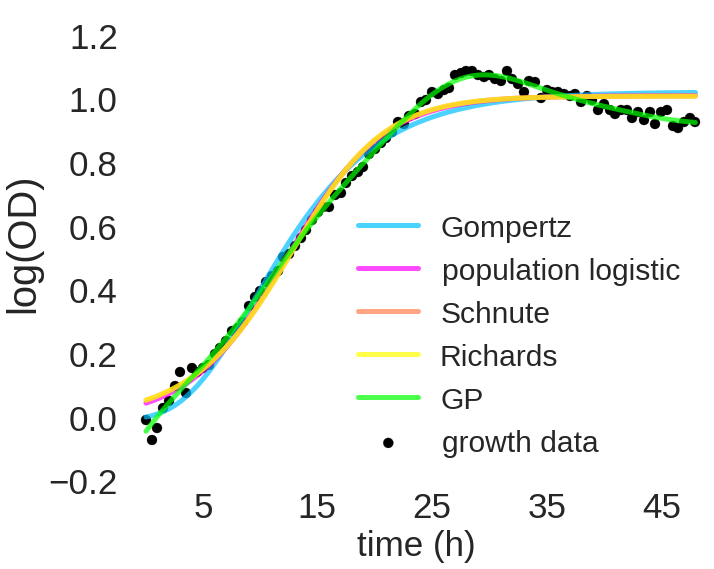

In [10]:
od = g.get_group(('ura3',0.33299999999999996)).values[10,timeind:]
od = np.log2(od.tolist())
od = od - od[0]

# plt.figure(figsize=(8,6))
plt.figure(figsize=(10,8))
plt.scatter(time,od,c='k',alpha=1,s=100,label='growth data')
plt.xlim(-2,49)
# plt.title("Oxidative stress",fontsize=40)
plt.xlabel("time (h)",fontsize=35)
plt.ylabel("log(OD)",fontsize=40)
plt.xticks([5,15,25,35,45],fontsize=35)
plt.ylim(-.2,1.3)
plt.yticks(fontsize=35)

linewidth=5
alpha=.7

m,A,l,mse = classical.optimize(time,od)
predict = np.array([classical.gompertz(t,m,A,l) for t in time])
plt.plot(time,predict,color="deepskyblue",linewidth=linewidth,label="Gompertz",alpha=alpha)

m,A,l,mse = classical.optimize(time,od,classical.logistic)
predict = np.array([classical.logistic(t,m,A,l) for t in time])
plt.plot(time,predict,color="magenta",linewidth=linewidth,label="population logistic",alpha=alpha)

p,_ = classical.curve_fit(classical.schnute,time,od,p0=(.1,1,1,.1,.1))
predict = np.array([classical.schnute(t,*p) for t in time])
plt.plot(time,predict,color="coral",linewidth=linewidth,label="Schnute",alpha=alpha)

p,_ = classical.curve_fit(classical.richards,time,od,p0=(.1,1,1,5))
predict = np.array([classical.richards(t,*p) for t in time])
plt.plot(time,predict,color="yellow",linewidth=linewidth,label="Richards",alpha=alpha)

gp = GPy.models.GPRegression(time.values[:,None],od[:,None])
gp.optimize()
predict = gp.predict(time.values[:,None])[0]
plt.plot(time,predict[:,0],color="lime",linewidth=linewidth,label="GP",alpha=alpha)
plt.legend(loc="best",fontsize=30)

plt.tight_layout()
plt.savefig('figures/oxidative_stress_example.png',bbox_inches="tight",dpi=300)

# Errors

In [6]:
output = pd.read_csv("classical_models.csv",index_col=None)

output = output.loc[~output.gp_mse.isnull(),:]
output = output.loc[~output.gompertz_mse.isnull(),:]
output = output.loc[~output.richards_mse.isnull(),:]
output = output.loc[~output.logistic_mse.isnull(),:]
output = output.loc[~output.schnute_mse.isnull(),:]

In [7]:
fits = output.copy()
fits.Condition.replace(np.nan,'',inplace=True)

In [8]:
fits.loc[fits['mM PQ'].isnull(),'mM PQ'] = 0

fits = fits[fits.Strain != "blank"]

In [9]:
g = fits.groupby(["mM PQ"])
g.groups.keys()

[0.0, 0.33300000000000002, 0.083000000000000004]

In [10]:
data1 = g.get_group((0))
# data1 = data1[data1.final_od>1]

# data2 = g.get_group((0,6,0))
data2 = g.get_group((0.33300000000000002))

In [11]:
print scipy.stats.ttest_ind(data1.gompertz_mse,data1.gp_mse), data1.gompertz_mse.mean()/data1.gp_mse.mean() 

(3.4889862038247119, 0.00054711134305245935) 5.26463648426


In [12]:
print scipy.stats.ttest_ind(data1.logistic_mse,data1.gp_mse), data1.logistic_mse.mean()/data1.gp_mse.mean() 

(7.607420885266686, 2.6397137361582893e-13) 8.89276562169


In [13]:
print scipy.stats.ttest_ind(data1.richards_mse[data1.richards_mse<.5],data1.gp_mse), data1.richards_mse[data1.richards_mse<.5].mean()/data1.gp_mse.mean()

(3.6531285430219667, 0.00029917319247269232) 4.22710877167


In [14]:
print scipy.stats.ttest_ind(data1.schnute_mse[~data1.schnute_mse.isnull()],data1.gp_mse), data1.schnute_mse[~data1.schnute_mse.isnull()].mean()/data1.gp_mse.mean()

(3.5255219558337427, 0.00047917650336690468) 4.1010257492


In [15]:
print scipy.stats.ttest_ind(data1.gompertz_mse,data1.logistic_mse) 

(-2.2887362241809952, 0.022693386607327667)


In [16]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k',offset=.01):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = "",markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height+height*offset,displaystring,ha = 'center',va='center',size = fontsize)

In [17]:
plt.figure(figsize=(12,8))

# sns.boxplot([data1.gompertz_mse,data1.logistic_mse,data1.gp_mse],names=['gompertz','logistic','gp'],
#             fliersize=5,color=['deepskyblue','magenta','lime'])
# sns.boxplot([data1.gompertz_mse,data1.logistic_mse,data1.schnute_mse,data1.gp_mse],names=['Gompertz','logistic','Schnute','gp'],
#             fliersize=5,color=['deepskyblue','magenta','coral','lime'])

sns.boxplot([data1.gompertz_mse,data1.logistic_mse,data1.schnute_mse,data1.richards_mse,data1.gp_mse],names=['Gompertz','population\nlogistic','Schnute','Richards','GP'],
            fliersize=5,color=['deepskyblue','magenta','coral','yellow','lime'])

plt.xticks(fontsize=25)
# plt.yticks([0.01,.03,.05,],fontsize=25)
# plt.ylim(-.001,.06)

# props = {'connectionstyle':'bar','arrowstyle':'-',\
#                  'shrinkA':60,'shrinkB':60,'lw':2}
# plt.annotate("*", xy=(.475,.0575), zorder=10,fontsize=20)
# plt.annotate('', xy=(0,.044), xytext=(1,.044), arrowprops=props)

significance_bar(1,5,40,'*',offset=.4,fontsize=25)
significance_bar(2,5,15,'*',offset=.4,fontsize=25)
significance_bar(3,5,5,'*',offset=.4,fontsize=25)
significance_bar(4,5,2,'*',offset=.4,fontsize=25)

# plt.title("Standard growth",fontsize=40)
plt.ylabel("MSE",fontsize=40)
plt.yscale('log',subsy=[])
plt.ylim(.00001,100)
plt.yticks(fontsize=35)

plt.tight_layout()

# plt.savefig("figures/mse_standard.png",dpi=300)

 /home/ptonner/dev/gp_growth_phenotype/lib/python2.7/site-packages/seaborn/categorical.py:1613: UserWarning:The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.


ValueError: to_rgb: Invalid rgb arg "('deepskyblue', 'magenta', 'coral', 'yellow', 'lime')"
sequence length is 5; must be 3 or 4

## Oxidative

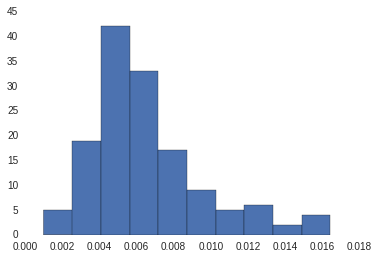

In [68]:
data2.gompertz_mse[~data2.gompertz_mse.isnull()].hist()

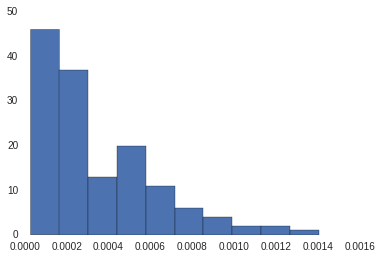

In [69]:
data2.gp_mse.hist()

In [70]:
for temp in [data2.gompertz_mse,data2.logistic_mse,data2.richards_mse,data2.schnute_mse]:
    print scipy.stats.ttest_ind(temp,data2.gp_mse,nan_policy='omit')[1] 

TypeError: ttest_ind() got an unexpected keyword argument 'nan_policy'

In [71]:
data2.gompertz_mse

120    0.002981
121    0.003545
122    0.003481
123    0.004572
124    0.004535
125    0.002482
126    0.002647
127    0.004227
128    0.004477
129    0.004585
130    0.004830
131    0.005057
132    0.004900
133    0.003590
134    0.002122
135    0.002330
136    0.003259
137    0.003289
138    0.003832
139    0.003176
140    0.003713
141    0.003612
142    0.004351
143    0.001387
144    0.003742
145    0.005010
146    0.004910
147    0.005206
148    0.005198
149    0.006168
         ...   
524    0.007813
525    0.007686
526    0.008291
527    0.008988
531    0.006710
532    0.007380
533    0.004838
535    0.007437
536    0.008348
537    0.008252
538    0.009966
539    0.008952
660    0.006832
661    0.010835
666    0.004004
667    0.006729
668    0.006031
670    0.015282
671    0.012173
677    0.003786
678    0.006867
680    0.004690
681    0.004533
682    0.004567
687    0.007442
690    0.006499
691    0.006890
692    0.004716
700    0.008195
701    0.008428
Name: gompertz_mse, dtyp

In [72]:
print scipy.stats.ttest_ind(data2.gompertz_mse,data2.gp_mse), data2.gompertz_mse.mean()/data2.gp_mse.mean()

(24.514583797991651, 7.3513639959013693e-72) 18.8006775704


In [76]:
print scipy.stats.ttest_ind(data2.logistic_mse,data2.gp_mse), data2.logistic_mse.mean()/data2.gp_mse.mean()

(21.582654276071423, 1.1449248491329349e-61) 17.3064125013


In [86]:
print scipy.stats.ttest_ind(data2.richards_mse,data2.gp_mse), (data2.richards_mse.mean()-data2.gp_mse.mean())/data2.gp_mse.mean()

(21.054376164358285, 8.6223464954294811e-60) 15.8516188541


In [87]:
print scipy.stats.ttest_ind(data2.schnute_mse,data2.gompertz_mse), data2.schnute_mse.mean()/data2.gp_mse.mean()

(-1.8758669886630575, 0.06170648826730632) 16.8473275999


In [83]:
print scipy.stats.ttest_ind(data1.gp_mse,data2.gp_mse), (data2.gp_mse.mean()-data1.gp_mse.mean())/data1.gp_mse.mean()

(-0.13194199393733841, 0.89511440761525085) 0.0262030288017


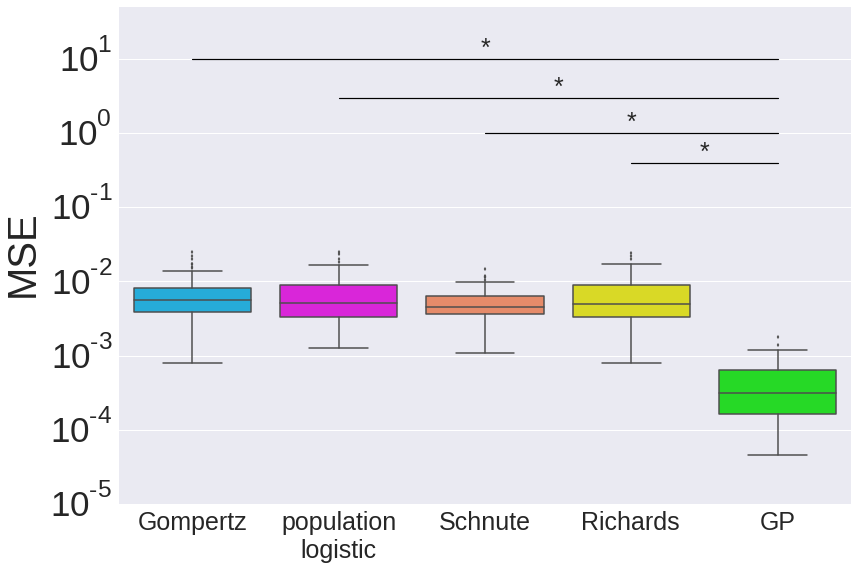

In [30]:
plt.figure(figsize=(12,8))

# sns.boxplot([data1.gompertz_mse,data1.logistic_mse,data1.gp_mse],names=['gompertz','logistic','gp'],
#             fliersize=5,color=['deepskyblue','magenta','lime'])
# sns.boxplot([data1.gompertz_mse,data1.logistic_mse,data1.schnute_mse,data1.gp_mse],names=['Gompertz','logistic','Schnute','gp'],
#             fliersize=5,color=['deepskyblue','magenta','coral','lime'])

sns.boxplot([data2.gompertz_mse,data2.logistic_mse,data2.schnute_mse[~data2.schnute_mse.isnull()],data2.richards_mse,data2.gp_mse[~data2.gp_mse.isnull()]],names=['Gompertz','population\nlogistic','Schnute','Richards','GP'],
            fliersize=3,color=['deepskyblue','magenta','coral','yellow','lime'])

plt.xticks(fontsize=25)

significance_bar(1,5,10,'*',offset=.4,fontsize=25)
significance_bar(2,5,3,'*',offset=.4,fontsize=25)
significance_bar(3,5,1,'*',offset=.4,fontsize=25)
significance_bar(4,5,.4,'*',offset=.4,fontsize=25)

# plt.title("Oxidative stress",fontsize=40)
plt.ylabel("MSE",fontsize=40)
plt.yscale('log',subsy=[])
plt.ylim(.00001,50)
plt.yticks(fontsize=35)

plt.tight_layout()

plt.savefig("figures/mse_paraquat.png",dpi=300)

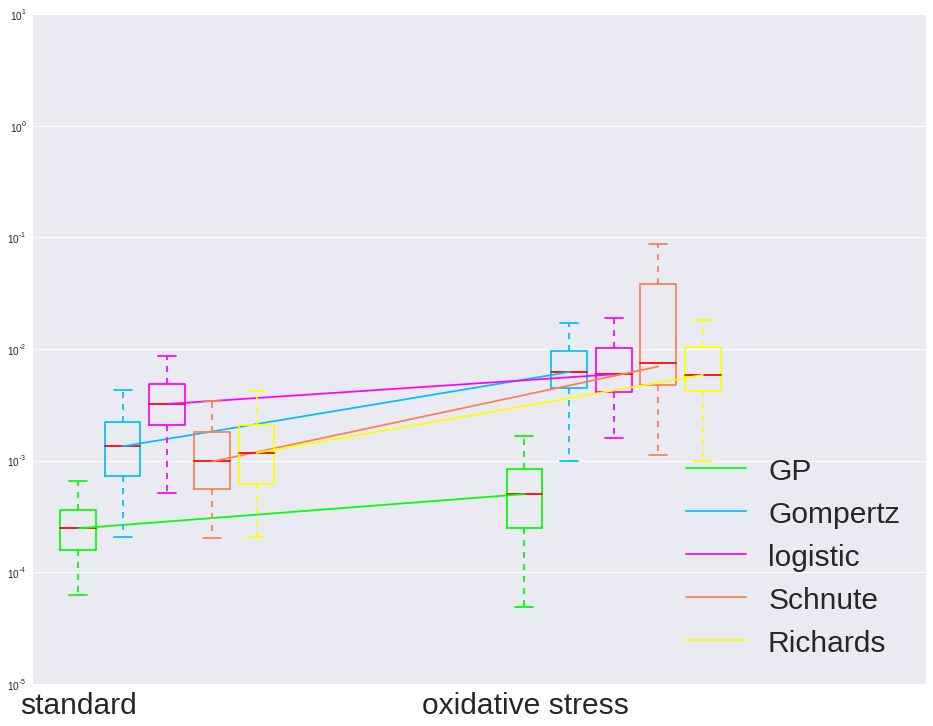

In [308]:
plt.figure(figsize=(16,12))

def plot_trend(d1,d2,c='b',offset=0,label=''):
    # sns.boxplot([d1,d2],color=[c,c],widths=.4)
    
    bp = plt.boxplot([d1,d2],widths=.08,positions=[1+offset,2+offset])
    plt.setp(bp['boxes'], color=c)
    plt.setp(bp['whiskers'], color=c)
    plt.setp(bp['caps'], color=c)
    plt.setp(bp['fliers'], color=c, marker='+')
    
    plt.plot([1+offset,2+offset],[d1.median(),d2.median()],c=c,label=label)

plot_trend(data1.gp_mse,data2.gp_mse[~data2.gp_mse.isnull()],'lime',0,'GP')
plot_trend(data1.gompertz_mse,data2.gompertz_mse,'deepskyblue',.1,'Gompertz')
plot_trend(data1.logistic_mse,data2.logistic_mse,'magenta',.2,'logistic')
plot_trend(data1.schnute_mse,data2.schnute_mse,'coral',.3,'Schnute')
plot_trend(data1.richards_mse,data2.richards_mse,'yellow',.4,'Richards')


plt.yscale('log',subsy=[])
plt.xticks([1,2],['standard','oxidative stress'],fontsize=30)
plt.legend(loc="best",fontsize=30)
plt.grid(False,axis='x')

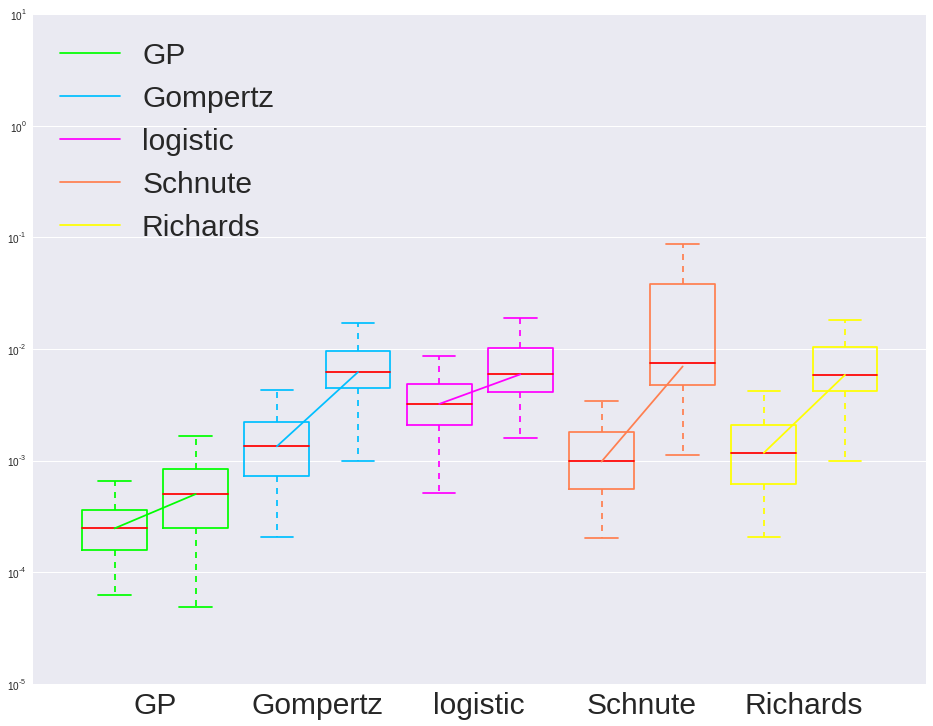

In [318]:
plt.figure(figsize=(16,12))

def plot_trend(d1,d2,c='b',offset=0,label=''):
    # sns.boxplot([d1,d2],color=[c,c],widths=.4)
    
    bp = plt.boxplot([d1,d2],widths=.4,positions=[offset,.5+offset])
    plt.setp(bp['boxes'], color=c)
    plt.setp(bp['whiskers'], color=c)
    plt.setp(bp['caps'], color=c)
    plt.setp(bp['fliers'], color=c, marker='+')
    
    plt.plot([offset,.5+offset],[d1.median(),d2.median()],c=c,label=label)


plot_trend(data1.gp_mse,data2.gp_mse[~data2.gp_mse.isnull()],'lime',0,'GP')
plot_trend(data1.gompertz_mse,data2.gompertz_mse,'deepskyblue',1,'Gompertz')
plot_trend(data1.logistic_mse,data2.logistic_mse,'magenta',2,'logistic')
plot_trend(data1.schnute_mse,data2.schnute_mse,'coral',3,'Schnute')
plot_trend(data1.richards_mse,data2.richards_mse,'yellow',4,'Richards')


plt.yscale('log',subsy=[])
plt.xticks([.25+tick for tick in range(5)],['GP','Gompertz','logistic','Schnute','Richards'],fontsize=30)
plt.xlim(-.5,5)
plt.legend(loc="best",fontsize=30)
plt.grid(False,axis='x')

## Runtime 

In [32]:
fits

,Well,Strain,Bio,Tech,Media,Condition,Plate Age,mM PQ,batch,gp_mse,...,logistic_CarryingCapacity,logistic_lagTime,logistic_mse,richards_muMax,richards_CarryingCapacity,richards_lagTime,richards_mse,schnute_muMax,schnute_lagTime,schnute_mse
1,102,asnC,A,1,CM,,23,0.000,20150517 PQ 3,NaN,...,1.894908,4.484036,0.000889,0.082768,1.908893,4.181989,0.000486,0.104009,4.181988,0.000486
2,103,asnC,A,2,CM,,23,0.000,20150517 PQ 3,NaN,...,1.961652,4.353655,0.001147,NaN,NaN,NaN,NaN,0.105144,3.886493,0.000261
3,104,asnC,A,3,CM,,23,0.000,20150517 PQ 3,NaN,...,1.920955,4.406870,0.001232,0.054079,1.949335,3.934242,0.000311,0.104195,3.934241,0.000311
4,105,asnC,B,1,CM,,23,0.000,20150517 PQ 3,NaN,...,1.972986,4.309367,0.001967,0.016896,2.017917,3.763051,0.000380,0.102471,3.763054,0.000380
5,106,asnC,B,2,CM,,23,0.000,20150517 PQ 3,NaN,...,1.936349,4.180832,0.001707,0.041690,1.969413,3.694620,0.000559,0.104665,3.694619,0.000559
6,107,asnC,B,3,CM,,23,0.000,20150517 PQ 3,NaN,...,1.921071,3.992330,0.002070,0.003334,1.968440,3.447956,0.000369,0.099610,3.447940,0.000369
7,108,asnC,C,1,CM,,23,0.000,20150517 PQ 3,NaN,...,1.814073,5.987415,0.000948,0.039342,1.851434,5.385509,0.000216,0.094960,5.385509,0.000216
8,109,asnC,C,2,CM,,23,0.000,20150517 PQ 3,NaN,...,1.747177,5.948553,0.001057,0.037135,1.780806,5.367074,0.000183,0.094329,5.367072,0.000183
10,111,asnC,C,3,CM,,23,0.000,20150517 PQ 3,NaN,...,2.026485,5.770307,0.001436,0.058960,2.061773,5.223811,0.000702,0.101371,5.223810,0.000702
11,112,asnC,D,1,CM,,23,0.000,20150517 PQ 3,NaN,...,2.398081,3.167208,0.004394,0.005752,1.640607,-10.062211,0.683998,0.105271,2.485698,0.000442


In [26]:
sns.set_palette('hls')

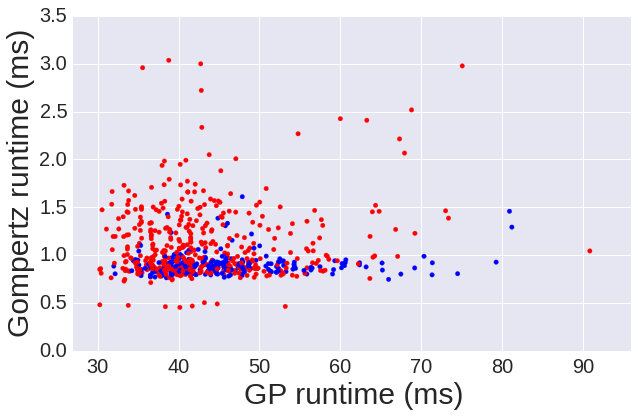

In [58]:
_,ax = plt.subplots(figsize=(10,6))
# plt.scatter(fits.gp_time/fits.gompertz_time.mean(),fits.gompertz_time/fits.gompertz_time.mean())
plt.scatter(fits.gp_time*1000,fits.gompertz_time*1000,color=['b' if x else 'r' for x in fits['mM PQ']==0])
# plt.ylim(0,.003)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GP runtime (ms)",fontsize=30)
plt.ylabel("Gompertz runtime (ms)",fontsize=30)
r = .9
ax.set_axis_bgcolor((r,r,r+.05))
plt.xlim(27,96)
# plt.grid(False)
# plt.xticks()

plt.savefig("figures/runtime.png",bbox_inches='tight')

In [1]:
fits.gp_time.mean(),fits.gompertz_time.mean()

NameError: name 'fits' is not defined

In [54]:
scipy.stats.pearsonr(fits.gp_time,fits.gompertz_time)

(-0.16493574014363405, 8.6471295134035574e-06)

## Parameters

In [18]:
fits = output.copy()
fits.Condition.replace(np.nan,'',inplace=True)

#remove problem batches
# fits = fits[~(fits.batch=="20150630 PQ 5").astype(bool)]


fits = fits[~fits.Condition.str.contains("blank")]
fits = fits[~fits.Strain.str.contains("blank")]
fits = fits[~fits.Strain.str.contains("empty")]
fits = fits[fits.gompertz_CarryingCapacity<4]

fits = fits[fits.gompertz_mse < .005]

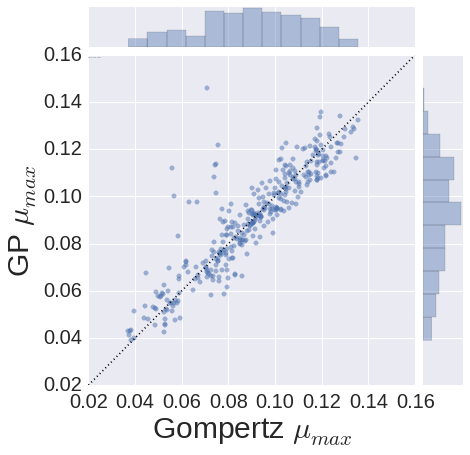

In [20]:
jp = sns.jointplot(fits.gompertz_muMax,fits.gp_muMax_mean,size=6,ratio=7,annot_kws={"fontsize":0},joint_kws={'alpha':.5}).set_axis_labels("Gompertz $\mu_{max}^{{}}$", "GP $\mu_{max}^{{}}$",fontsize=30)
[t.set_fontsize(20) for t in jp.ax_joint.get_xticklabels()]
[t.set_fontsize(20) for t in jp.ax_joint.get_yticklabels()]

# add equality line
x0, x1 = jp.ax_joint.get_xlim()
y0, y1 = jp.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
jp.ax_joint.plot(lims, lims, ':k')
jp.ax_joint.set_xlim(lims)
jp.ax_joint.set_ylim(lims)

plt.savefig("figures/muMax_diff.pdf",bbox_inches="tight")

In [40]:
outlier = output[output.gp_muMax_mean==output.gp_muMax_mean.max()]
outlier

,Well,Strain,Bio,Tech,Media,Condition,Plate Age,mM PQ,batch,gp_mse,...,logistic_CarryingCapacity,logistic_lagTime,logistic_mse,richards_muMax,richards_CarryingCapacity,richards_lagTime,richards_mse,schnute_muMax,schnute_lagTime,schnute_mse
236,137,idr2,D,2,CM,NaN,21,0,20150630 PQ 5,0.009836,...,2.578221,7.572245,0.061013,0.115474,2.371232,10.530717,0.051254,0.096587,10.530663,0.051254


In [41]:
outlier.iloc[:,9:15]

,gp_mse,gp_muMax_mean,gp_muMax_std,gp_CarryingCapacity_mean,gp_CarryingCapacity_std,gp_loglikelihood
236,0.009836,0.450818,0.003698,2.418995,0.01448,24.490602


In [42]:
outlier.iloc[:,15:19]

,gp_time,gompertz_muMax,gompertz_CarryingCapacity,gompertz_lagTime
236,0.035082,0.072024,3.064544,5.106093


In [44]:
outlierData = data[(data.Well==outlier.Well.values[0])&(data.batch==outlier.batch.values[0])]

In [45]:
x,y = outlierData.columns[timeind:].astype(float).values,outlierData.values[0,timeind:]
x = x[:,None]
y = y[:,None]
gp = GPy.models.GPRegression(x,y)
gp.optimize()

mu,var = gp.predict(x)

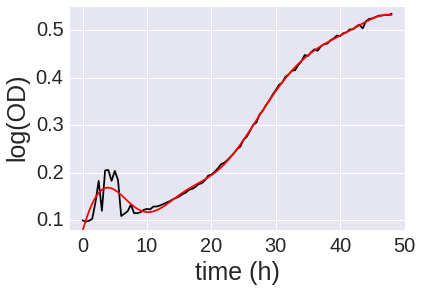

In [57]:
_,ax = plt.subplots()
plt.plot(outlierData.columns[timeind:].astype(float).values,outlierData.values[0,timeind:],c='k')
plt.plot(x,mu,c='r')
# plt.plot(x,classical.gompertz(x,
#                               outlier.gompertz_muMax.values[0],
#                               outlier.gompertz_CarryingCapacity.values[0],
#                               outlier.gompertz_lagTime.values[0]))
plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
r = .9
ax.set_axis_bgcolor((r,r,r+.05))
plt.ylim(.08,.55)
plt.xlim(-2,50)
plt.savefig("figures/figureS3-new.pdf",bbox_inches="tight")

In [69]:
outlierData.values[:,timeind:]

array([[0.1, 0.09699999999999999, 0.099, 0.10300000000000001, 0.138, 0.183,
        0.12, 0.205, 0.20600000000000002, 0.183, 0.204, 0.185, 0.109,
        0.114, 0.11900000000000001, 0.133, 0.115, 0.115,
        0.11699999999999999, 0.122, 0.124, 0.12300000000000001, 0.129,
        0.129, 0.131, 0.134, 0.13699999999999998, 0.14,
        0.14400000000000002, 0.147, 0.15, 0.155, 0.158,
        0.16399999999999998, 0.166, 0.17, 0.17600000000000002,
        0.17800000000000002, 0.184, 0.19399999999999998, 0.196,
        0.20199999999999999, 0.209, 0.218, 0.221, 0.22699999999999998,
        0.23399999999999999, 0.24100000000000002, 0.25, 0.255, 0.27, 0.276,
        0.28800000000000003, 0.301, 0.306, 0.32299999999999995, 0.331,
        0.34299999999999997, 0.35200000000000004, 0.364, 0.374, 0.385,
        0.39, 0.402, 0.40700000000000003, 0.415, 0.41600000000000004,
        0.42700000000000005, 0.435, 0.44799999999999995, 0.446,
        0.45399999999999996, 0.46, 0.457, 0.466, 0.4710000000000

In [59]:
scipy.stats.pearsonr(fits.gompertz_muMax,fits.gp_muMax_mean)

(0.91619250485842318, 2.2279662168554561e-221)

In [423]:
scipy.stats.pearsonr(fits.gompertz_muMax,fits.gp_muMax_mean)

(0.90335355103960024, 4.2995319429115845e-205)

In [424]:
scipy.stats.pearsonr(fits.gompertz_CarryingCapacity,fits.gp_CarryingCapacity_mean)

(0.94668139920546412, 1.0432760339431955e-273)

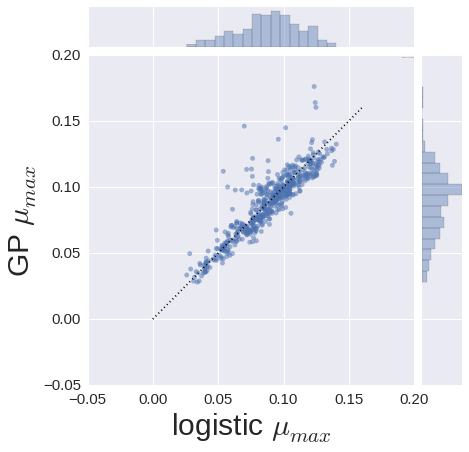

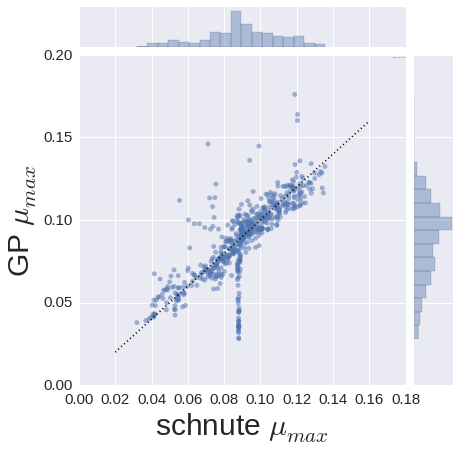

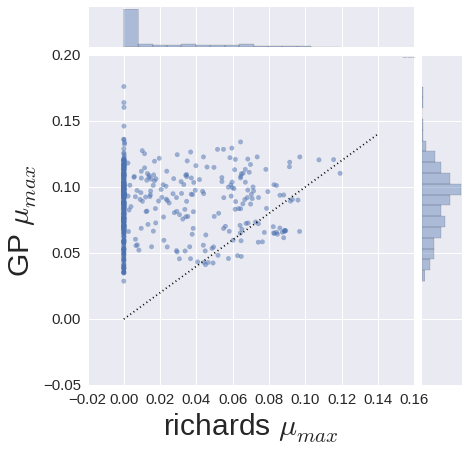

In [404]:
for model in ['logistic','schnute','richards']:
    jp = sns.jointplot(fits['%s_muMax'%model],fits.gp_muMax_mean,size=6,ratio=7,annot_kws={"fontsize":0},joint_kws={'alpha':.5}).set_axis_labels("%s $\mu_{max}^{{}}$" % model, "GP $\mu_{max}^{{}}$",fontsize=30)
    [t.set_fontsize(15) for t in jp.ax_joint.get_xticklabels()]
    [t.set_fontsize(15) for t in jp.ax_joint.get_yticklabels()]

    # add equality line
    x0, x1 = jp.ax_joint.get_xlim()
    y0, y1 = jp.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    jp.ax_joint.plot(lims, lims, ':k')

    plt.savefig("figures/muMax_diff_%s.png"%model,bbox_inches="tight")

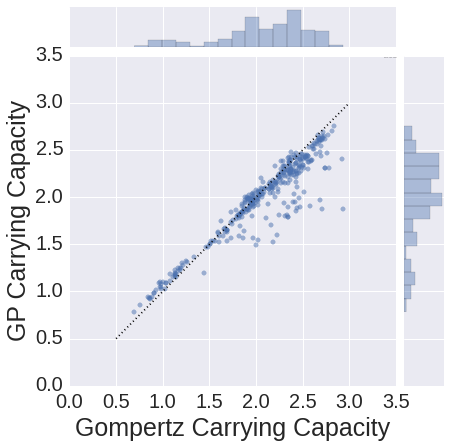

In [21]:
jp = sns.jointplot(fits.gompertz_CarryingCapacity,fits.gp_CarryingCapacity_mean,size=6,ratio=7,annot_kws={"fontsize":0},joint_kws={'alpha':.5}).set_axis_labels("Gompertz Carrying Capacity", "GP Carrying Capacity",fontsize=25)
[t.set_fontsize(20) for t in jp.ax_joint.get_xticklabels()]
[t.set_fontsize(20) for t in jp.ax_joint.get_yticklabels()]

# add equality line
x0, x1 = jp.ax_joint.get_xlim()
y0, y1 = jp.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
jp.ax_joint.plot(lims, lims, ':k')  

plt.savefig("figures/carryCapp_diff.pdf",bbox_inches="tight")

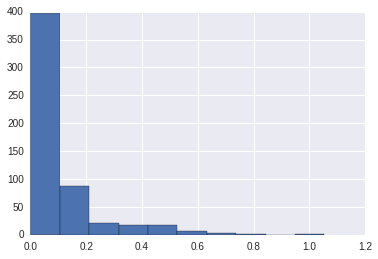

In [427]:
diff = fits.gompertz_CarryingCapacity-fits.gp_CarryingCapacity_mean
diff.abs().hist()

In [433]:
data.columns

Index([u'Well', u'Strain', u'Bio', u'Tech', u'Media', u'Condition',
       u'Plate Age', u'mM PQ', u'batch', u'0.0',
       ...
       u'43.5', u'44.0', u'44.5', u'45.0', u'45.5', u'46.0', u'46.5', u'47.0',
       u'47.5', u'48.0'],
      dtype='object', length=106)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


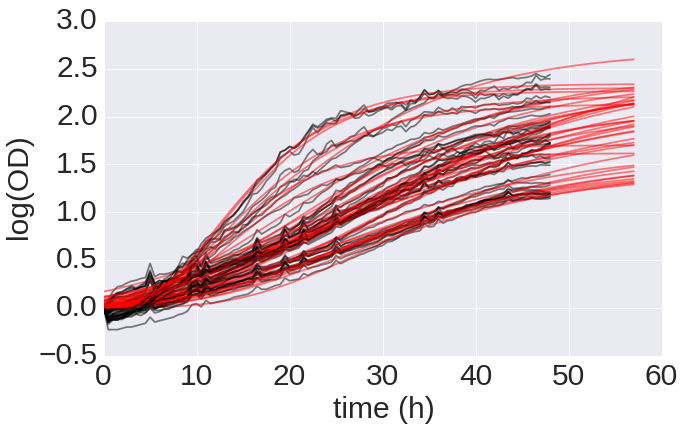

In [478]:
time = data.columns[timeind:].values.astype(float)
time_extend = time.astype(float).tolist() + np.arange(time.max()+1,time.max()+10).tolist()

plt.figure(figsize=(10,6))

for i in range(sum(diff.abs()>.25)):
    temp = data[np.all(data.iloc[:,:9] == fits[diff.abs()>.25].iloc[i,:9],1)]
    
    if temp.shape[0] == 0:
        print i
        continue
    
    od = np.log2(temp.iloc[:,timeind:].values.T)
    od = od - od[0]
    
    plt.plot(time,od,'k',alpha=.5)
    
    mm,cc,l = fits[diff.abs()>.25].iloc[i,:][['gompertz_muMax','gompertz_CarryingCapacity','gompertz_lagTime']]
    plt.plot(time_extend,classical.gompertz(time_extend,mm,cc,l),'r',alpha=.5)
    
plt.xlabel("time (h)",fontsize=30)
plt.ylabel("log(OD)",fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig("figures/cc_difference_samples.png",bbox_inches="tight")

In [472]:
time.astype(float).tolist() + np.arange(time.max()+1,time.max()+10).tolist()

array([ -4.84928562,  -4.34928562,  -3.84928562,  -3.34928562,
        -2.84928562,  -2.34928562,  -1.84928562,  -1.34928562,
        -0.84928562,  -0.34928562,   0.15071438,   0.65071438,
         1.15071438,   1.65071438,   2.15071438,   2.65071438,
         3.15071438,   3.65071438,   4.15071438,   4.65071438,
         5.15071438,   5.65071438,   6.15071438,   6.65071438,
         7.15071438,   7.65071438,   8.15071438,   8.65071438,
         9.15071438,   9.65071438,  10.15071438,  10.65071438,
        11.15071438,  11.65071438,  12.15071438,  12.65071438,
        13.15071438,  13.65071438,  14.15071438,  14.65071438,
        15.15071438,  15.65071438,  16.15071438,  16.65071438,
        17.15071438,  17.65071438,  18.15071438,  18.65071438,
        19.15071438,  19.65071438,  20.15071438,  20.65071438,
        21.15071438,  21.65071438,  22.15071438,  22.65071438,
        23.15071438,  23.65071438,  24.15071438,  24.65071438,
        25.15071438,  25.65071438,  26.15071438,  26.65

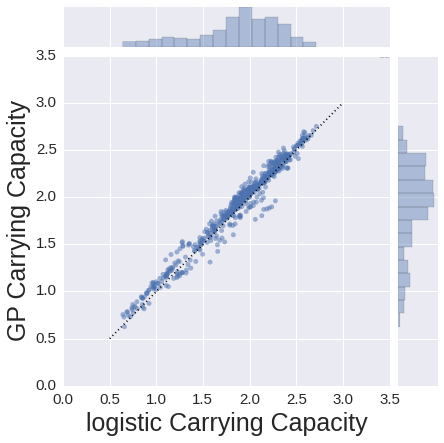

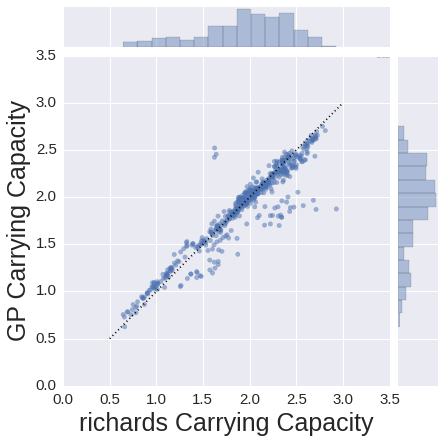

In [410]:
for model in ['logistic','richards']:
    jp = sns.jointplot(fits['%s_CarryingCapacity'%model],fits.gp_CarryingCapacity_mean,size=6,ratio=7,annot_kws={"fontsize":0},joint_kws={'alpha':.5}).set_axis_labels("%s Carrying Capacity"%model, "GP Carrying Capacity",fontsize=25)
    [t.set_fontsize(15) for t in jp.ax_joint.get_xticklabels()]
    [t.set_fontsize(15) for t in jp.ax_joint.get_yticklabels()]

    # add equality line
    x0, x1 = jp.ax_joint.get_xlim()
    y0, y1 = jp.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    jp.ax_joint.plot(lims, lims, ':k')  

    plt.savefig("figures/carryCapp_diff_%s.png"%model,bbox_inches="tight")

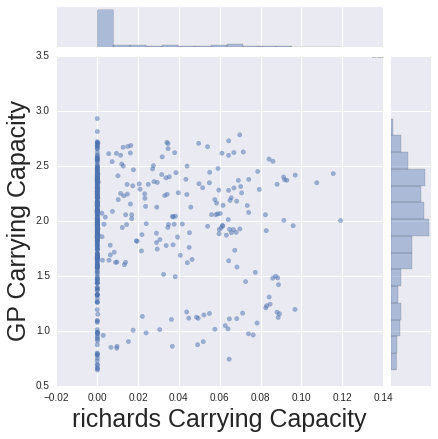

In [411]:
jp = sns.jointplot(fits.richards_muMax,fits.richards_CarryingCapacity,size=6,ratio=7,annot_kws={"fontsize":0},joint_kws={'alpha':.5}).set_axis_labels("%s Carrying Capacity"%model, "GP Carrying Capacity",fontsize=25)

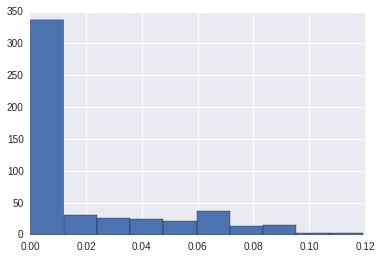

In [419]:
fits.richards_muMax[~fits.richards_muMax.isnull()].hist()

In [415]:
np.isclose(fits.richards_muMax,0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [418]:
fits.richards_muMax.isnull()

1      False
2       True
3      False
4      False
5      False
6      False
7      False
8      False
10     False
11     False
12     False
13      True
14     False
15      True
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
       ...  
711    False
712    False
713    False
714    False
715    False
716    False
717    False
718     True
719     True
721    False
722    False
723    False
724    False
725    False
728    False
729    False
730    False
731    False
732    False
738    False
742    False
743    False
746    False
747    False
748    False
749    False
752    False
755    False
758    False
768    False
Name: richards_muMax, dtype: bool